# Make Paper Figures

This notebook is used to produce the final figures as included within the manuscript.

In [1]:
from funcs import get_parc_sizes
from plot_funcs import (get_results, plot_avg_ranks, get_ranks_sizes, get_across_ranks, add_extra_ticks,
                        get_single_vs_multiple_df, mean_score,
                        get_results_df, get_intra_pipeline_df, get_highest_performing_df,
                        get_mean_avg_ranks)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
# Load results
results = get_results('../exp/results')
parc_sizes = get_parc_sizes(everything=True)

static = {'random': True, 'base': True, 'fs': True, 'ico': True}

Found: 64530 Incomplete: 0


# Averaged Performance-Size Scaling

### Figure 2 - Mean across pipelines

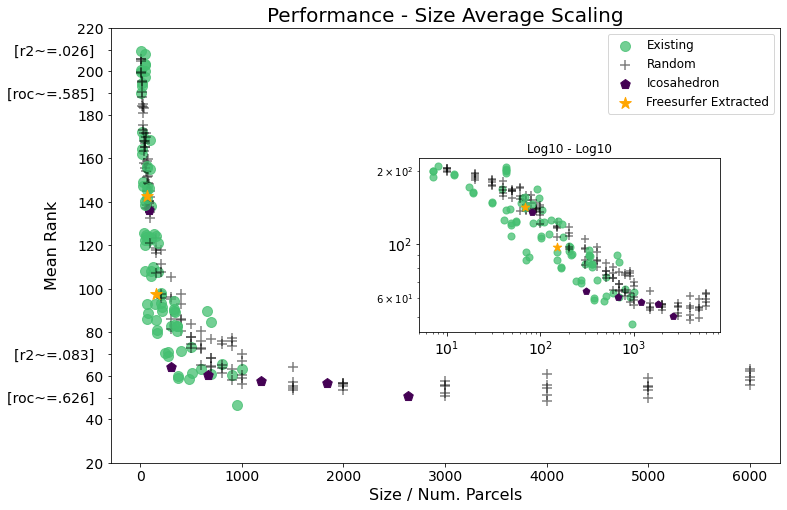

In [3]:
# Main figure + subplot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
axins = inset_axes(ax, width="45%", height="40%", borderpad=6, loc=7)

plot_avg_ranks(results, **static, log=False, ax=ax)
plot_avg_ranks(results, **static, log=True, ax=axins, sm=.5)

axins.set_xlabel('')
axins.set_ylabel('')
axins.set_title('Log10 - Log10')
axins.get_legend().remove()

# Get reference for adding r2 ticks
ref = get_ranks_sizes(results, log=False, by_group=False, add_raw=True, **static)

add_extra_ticks(ax, ref, r2_extra_ticks=[210, 70],
                         roc_extra_ticks=[190, 50])

ax.set_title('Performance - Size Average Scaling', fontsize=20)
plt.savefig('Figures/Figure2.png', dpi=500, bbox_inches='tight')

# Choice of Pipeline

### Figure 3 - Comparison

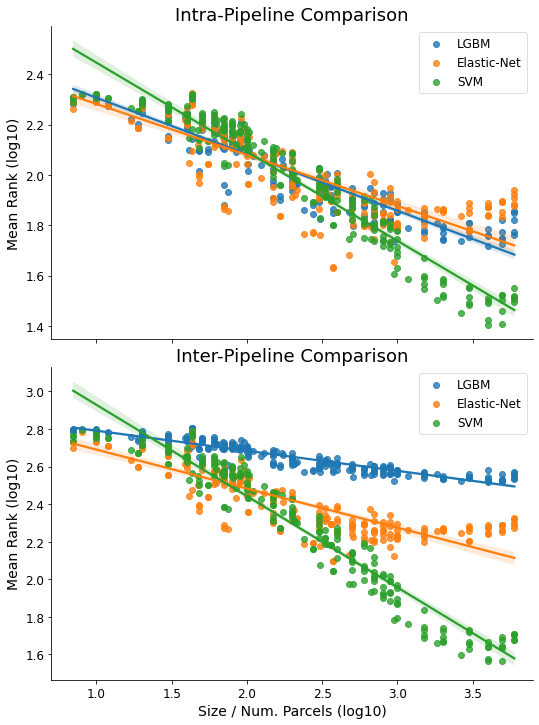

In [4]:
# Make a combined df with both intra and inter
intra_pipe_df = get_intra_pipeline_df(results, log=True,
                                      threshold=False, **static)
inter_pipe_df = get_across_ranks(results, log=True, **static)

intra_pipe_df['Comparison Type'] = 'Intra-Pipeline'
inter_pipe_df['Comparison Type'] = 'Inter-Pipeline'

combined_df = pd.concat([intra_pipe_df, inter_pipe_df])
combined_df = combined_df.rename(columns={'Mean_Rank': 'Mean Rank',
                                          'Model': 'Pipeline', 'Size': 'Num. Parcels'})
combined_df = combined_df.replace({'lgbm': 'LGBM', 'elastic': 'Elastic-Net', 'svm':'SVM'})

g = sns.lmplot(y='Mean Rank', x='Num. Parcels',
               data=combined_df, hue='Pipeline',
               row='Comparison Type', facet_kws=dict(sharey=False),
               aspect=1.5, robust=True, legend=False)

g.set(xlim=(.7, 3.9))

sns.set_context("paper", rc={"axes.fontsize":16})  

g.axes[0][0].set_title('Intra-Pipeline Comparison', fontsize=18)
g.axes[1][0].set_title('Inter-Pipeline Comparison', fontsize=18)

# Set axis attributes / sizes
g.axes[1][0].set_xlabel('Size / Num. Parcels (log10)', fontsize=14)

for i in [0, 1]:
    g.axes[i][0].set_ylabel('Mean Rank (log10)', fontsize=14)
    g.axes[i][0].xaxis.set_tick_params(labelsize=12)
    g.axes[i][0].yaxis.set_tick_params(labelsize=12)

g.axes[0][0].legend(fontsize=12)
g.axes[1][0].legend(fontsize=12)

plt.savefig('Figures/Figure3.png', dpi=300, bbox_inches='tight')

# Variation Across Target Variable

### Figure 4 - By Target Averaged Scaling

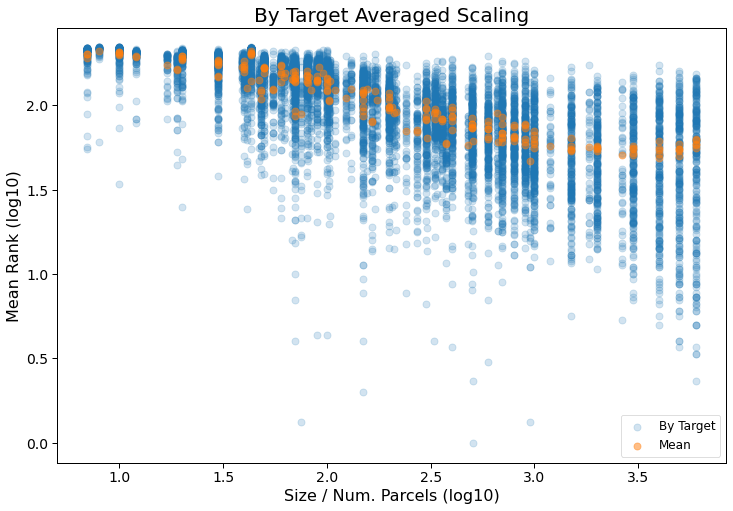

In [5]:
r_df = get_ranks_sizes(results, log=True,
                       avg_targets=False, **static)
mean_df = get_ranks_sizes(results, log=True,
                       avg_targets=True, **static)

plt.figure(figsize=(12, 8))
plt.scatter(r_df['Size'], r_df['Mean_Rank'],
            alpha=.2, s=50, label='By Target')
plt.scatter(mean_df['Size'], mean_df['Mean_Rank'],
            alpha=.5, s=50, label='Mean')
plt.legend(frameon=True, loc=4, fontsize=12)

plt.ylabel('Mean Rank (log10)', fontsize=16)
plt.xlabel('Size / Num. Parcels (log10)', fontsize=16)

plt.tick_params(labelsize=14)
plt.tick_params(labelsize=14)

plt.title('By Target Averaged Scaling', fontsize=20)
plt.savefig('Figures/Figure4.png', dpi=300, bbox_inches='tight')

# Single vs. Multiple Parcellations

### Figure 5

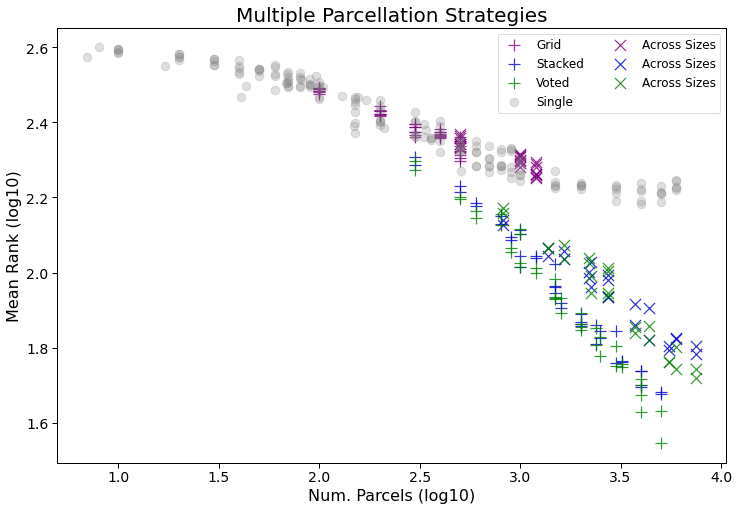

In [6]:
r_df = get_single_vs_multiple_df(results, log=True,
                                 stacked=True,
                                 voted=True, grid=True,
                                 **static)

n = r_df[r_df['across_sizes'] == 0]
ac = r_df[r_df['across_sizes'] == 1]

# Make plot
plt.figure(figsize=(12, 8))

g0, g1 = n.loc['Grid'], ac.loc['Grid']
g0_x = plt.scatter(g0['Size'], g0['Mean_Rank'],
                   marker='+', color='purple', s=125, alpha=.8)
g1_x = plt.scatter(g1['Size'], g1['Mean_Rank'],
                   marker='x', color='purple', s=125, alpha=.8)

s0, s1 = n.loc['Stacked'], ac.loc['Stacked']
s0_x = plt.scatter(s0['Size'], s0['Mean_Rank'],
                   marker='+', color='mediumblue', s=125, alpha=.8)
s1_x = plt.scatter(s1['Size'], s1['Mean_Rank'],
                   marker='x', color='mediumblue', s=125, alpha=.8)

v0, v1 = n.loc['Voted'], ac.loc['Voted']
v0_x = plt.scatter(v0['Size'], v0['Mean_Rank'],
                   marker='+', color='green', s=125, alpha=.8)
v1_x = plt.scatter(v1['Size'], v1['Mean_Rank'],
                   marker='x', color='green', s=125, alpha=.8)
s = plt.scatter(n.loc['Single']['Size'], n.loc['Single']['Mean_Rank'],
                   color='gray', s=75, alpha=.25)

plt.legend([g0_x, s0_x, v0_x, s,
            g1_x, s1_x, v1_x],
           ['Grid', 'Stacked', 'Voted', 'Single',
            'Across Sizes', 'Across Sizes', 'Across Sizes'],
           ncol=2, fontsize=12)

plt.xlabel('Num. Parcels (log10)', fontsize=16)
plt.ylabel('Mean Rank (log10)', fontsize=16)

plt.tick_params(labelsize=14)
plt.tick_params(labelsize=14)

plt.title('Multiple Parcellation Strategies', fontsize=20)
plt.savefig('Figures/Figure5.png', dpi=300, bbox_inches='tight')

# Highest Performance

### Figure 6

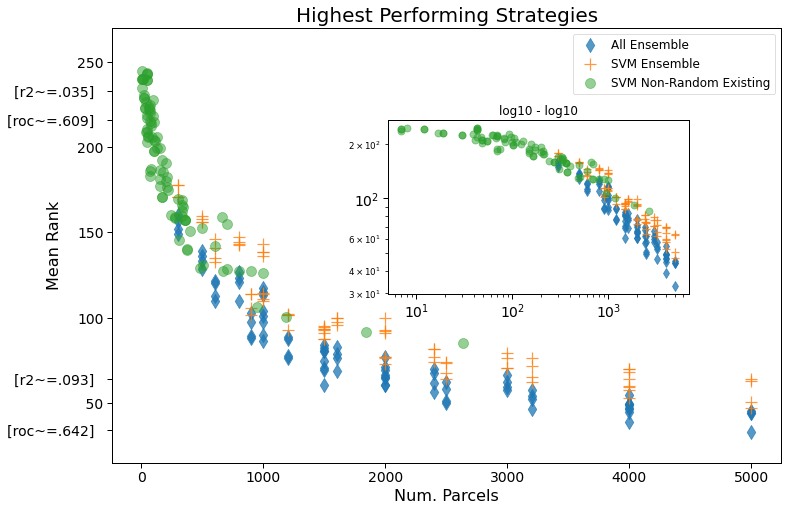

In [7]:
# Get scores df
scores = get_highest_performing_df(results)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

plt.title('Highest Performing Strategies', fontsize=20)
axins = inset_axes(ax, width="45%", height="40%", borderpad=10.5)
plt.title('log10 - log10', fontsize=12)

for i, a in enumerate([ax, axins]):
    
    j = i + 1
    
    if i == 1:
        a.set_xscale('log')
        a.set_yscale('log')

    a.scatter(scores.loc['all', 'Size'],
              scores.loc['all', 'Mean_Rank'],
              label='All Ensemble', s=100 // j, marker='d', alpha=.75)

    a.scatter(scores.loc['svm', 'Size'],
              scores.loc['svm', 'Mean_Rank'],
              label='SVM Ensemble', s=125 // j, marker='+', alpha=.8)

    a.scatter(scores.loc['existing', 'Size'],
              scores.loc['existing', 'Mean_Rank'],
              label='SVM Non-Random Existing', s=100 // j, alpha=.5)
    
ax.set_ylabel('Mean Rank', fontsize=16)
ax.set_xlabel('Num. Parcels', fontsize=16)


# Add custom ticks
ref = scores.copy().set_index('Parcellation')

add_extra_ticks(ax, ref, r2_extra_ticks=[233, 64],
                         roc_extra_ticks=[216, 34])

# Sizes
ax.legend(fontsize=12)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
axins.xaxis.set_tick_params(labelsize=14)
axins.yaxis.set_tick_params(labelsize=14)

ax.set_ylim(bottom=15, top=270)

plt.savefig('Figures/Figure6.png', dpi=300, bbox_inches='tight')